In [264]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random


from termcolor import colored

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Model
# --------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [265]:
def metricas(validacion, prediccion, churm):
    
    print("Exactitud: ", metrics.accuracy_score(validacion, prediccion))
    print("Kappa: ", metrics.cohen_kappa_score(validacion, prediccion))
    
    print(colored('Predicciones de los registros mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[1], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[1], average='macro'))
    
    VP = np.sum(churm[1:2,1:2])
    FN = np.sum(churm[1,0:1])
    specificity = VP/(VP+FN)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[1], average='macro'))
    
    
    print(colored('Predicciones de los registros no mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[0], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[0], average='macro'))
    
    VP = np.sum(churm[0:1,0:1])
    FN = np.sum(churm[0,1:2])
    specificity = VP/(VP+FN)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[0], average='macro'))

In [266]:
def matriz_confusion(validacion, prediccion, cmap):
    print(colored('Matriz de confusión', attrs=['bold']))
    churm = metrics.confusion_matrix(validacion, prediccion)
    plt.imshow(churm, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not_mine','Mine'])
    plt.yticks(tick_marks, ['Not_mine','Mine'])
    return churm

# Load Data

In [267]:
dataA = pd.read_csv('./data_identificada.csv').drop(['index','Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataA.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
0,400,TCP,0.0,0.0,9.04175,4287.992,65.519,0.0,6750,360512,...,53.0,80.0,1.0,1.0,5.5,32.0,33.0,873.0,not_mine,Does not have


# Preprocesamiento

### Imputación de valores ausentes

In [268]:
punter = pd.concat([dataA['second_sp'],dataA['second_dp'],dataA['third_sp'],dataA['third_dp']],axis=1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
values = imputer.fit_transform(punter)

In [269]:
punter = pd.DataFrame(values, columns = punter.columns)
dataA['second_sp'] = punter['second_sp']
dataA['second_dp'] = punter['second_dp']
dataA['third_sp'] = punter['third_sp']
dataA['third_dp'] = punter['third_dp']

In [270]:
dataCopyA = dataA

### OneHotEncoder

In [271]:
data_categoric = dataA[dataA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<4733x12 sparse matrix of type '<class 'numpy.float64'>'
	with 14199 stored elements in Compressed Sparse Row format>

In [272]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,Cryptocurrency_Does not have,Cryptocurrency_Etherium,Cryptocurrency_Litecoin,Cryptocurrency_Monero
0,0,0,1,0,0,1,0,0,1,0,0,0
1,0,0,0,1,0,1,0,0,1,0,0,0


### Estructuración

In [273]:
dataA = dataA.drop(data_categoric, axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib'],
      dtype='object')

In [274]:
dataA = pd.concat([dataA,data_dummy], axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine', 'Type_not_mine',
       'Cryptocurrency_Bitcash', 'Cryptocurrency_Bitcoin',
       'Cryptocurrency_Does not have', 'Cryptocurrency_Etherium',
       'Cryptocurrency_Litecoin', 'Cryptocurrency_Monero'],
      dtype='object')

# Árbol de decisión

Mejores caracteristicas del conjunto de datos puros

In [275]:
best_feature_sel = ['#dp', '#sp', 'Avg_bpp', 'first_dp', 'first_sp', 'min_d', 'p1_d',
       'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_ib', 'second_dp',
       'second_sp']

In [276]:
X = dataA[best_feature_sel]
y = dataA['Type_mine']

### Holdout

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)

### Modelo

In [278]:
print(colored('Instancio el modelo de arbol de decisión', attrs=['bold']))
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

Instancio el modelo de arbol de decisión


In [279]:
print(colored('Entreno el modelo', attrs=['bold']))
model.fit(X_train,y_train)

Entreno el modelo


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Grafico el modelo
Profundidad del árbol: 4
Número de nodos terminales: 5


[Text(159.42857142857142, 489.24, 'first_sp <= 1887.5\nsamples = 3313\nvalue = [1758, 1555]\nclass = T'),
 Text(79.71428571428571, 380.52000000000004, 'samples = 1734\nvalue = [1734, 0]\nclass = T'),
 Text(239.1428571428571, 380.52000000000004, 'p3_ib <= 178.0\nsamples = 1579\nvalue = [24, 1555]\nclass = i'),
 Text(159.42857142857142, 271.8, 'samples = 21\nvalue = [21, 0]\nclass = T'),
 Text(318.85714285714283, 271.8, 'first_dp <= 2616.0\nsamples = 1558\nvalue = [3, 1555]\nclass = i'),
 Text(239.1428571428571, 163.08000000000004, 'samples = 2\nvalue = [2, 0]\nclass = T'),
 Text(398.57142857142856, 163.08000000000004, '#dp <= 5.5\nsamples = 1556\nvalue = [1, 1555]\nclass = i'),
 Text(318.85714285714283, 54.360000000000014, 'samples = 1555\nvalue = [0, 1555]\nclass = i'),
 Text(478.2857142857142, 54.360000000000014, 'samples = 1\nvalue = [1, 0]\nclass = T')]

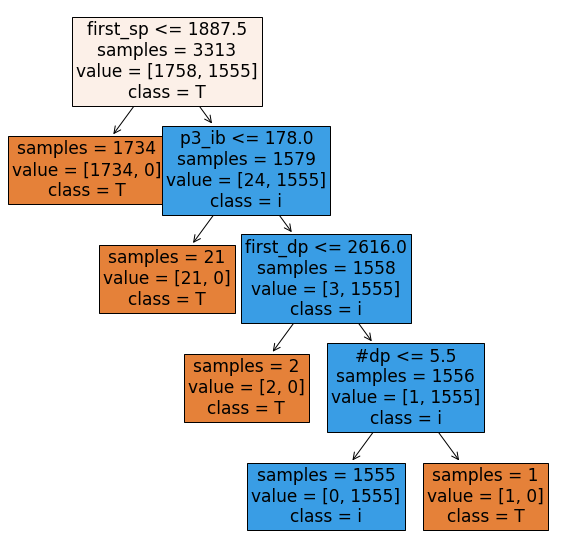

In [280]:
print(colored('Grafico el modelo', attrs=['bold']))
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [281]:
print(colored('Realizo la predicción del modelo con la porción de prueba', attrs=['bold']))
y_pred = model.predict(X_test)
y_pred

Realizo la predicción del modelo con la porción de prueba


array([0, 0, 0, ..., 1, 0, 0], dtype=uint8)

In [282]:
len(y_pred[y_pred == 0])

744

In [283]:
len(y_pred[y_pred == 1])

676

### Métricas y matriz de confusión

Matriz de confusión


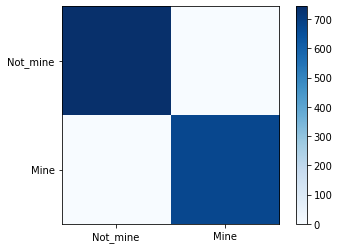

In [284]:
churm = matriz_confusion(y_test, y_pred, plt.cm.Blues)

In [285]:
pd.DataFrame(churm)

,0,1
0,743,0
1,1,676


In [286]:
metricas(y_test, y_pred, churm)

Exactitud:  0.9992957746478873
Kappa:  0.998588407445256
Predicciones de los registros mineros
Precisión:  1.0
Recall:  0.9985228951255539
Especificidad :  0.9985228951255539
F1-score      :  0.999260901699926
Predicciones de los registros no mineros
Precisión:  0.9986559139784946
Recall:  1.0
Especificidad :  1.0
F1-score      :  0.9993275050437123


# Experimento 1

In [287]:
print(colored('Importo el conjunto de datos no puros', attrs=['bold']))
dataB = pd.read_csv('./data_no_identificada.csv')
dataB.columns

Importo el conjunto de datos no puros


Index(['index', 'Name', 'Netflows', 'First_Protocol', 'Second_Protocol',
       'Third_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'Type', 'Cryptocurrency'],
      dtype='object')

In [288]:
dataB.shape

(39554, 33)

In [289]:
print(colored('Valores faltantes del conjunto no puro', attrs=['bold']))
dataB.isnull().sum()

Valores faltantes del conjunto no puro


index                  0
Name                   0
Netflows               0
First_Protocol         0
Second_Protocol     6133
Third_Protocol     18674
p1_d                   0
p2_d                   0
p3_d                   0
duration               0
max_d                  0
min_d                  0
#packets               0
Avg_bps                0
Avg_pps                0
Avg_bpp                0
#Bytes                 0
#sp                    0
#dp                    0
first_sp               0
second_sp           7498
third_sp           10993
first_dp               0
second_dp           1708
third_dp            7103
p1_ip                  0
p2_ip                  0
p3_ip                  0
p1_ib                  0
p2_ib                  0
p3_ib                  0
Type                   0
Cryptocurrency         0
dtype: int64

In [290]:
print(colored('Elimino valores faltantes del conjunto de datos no puros, ya que estamos poniendo a prueba nuestro primer modelo, con datos tomados de ambientes no controlados, con la finalidad de observar como se comporta.', attrs=['bold']))

dataB = dataB.dropna()

Elimino valores faltantes del conjunto de datos no puros, ya que estamos poniendo a prueba nuestro primer modelo, con datos tomados de ambientes no controlados, con la finalidad de observar como se comporta.


In [291]:
dataB.shape

(19640, 33)

In [292]:
X = dataB[best_feature_sel]
y = dataB['Type'].replace({'mine':1,'not_mine':0})

In [293]:
y_pred = model.predict(X)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

Matriz de confusión


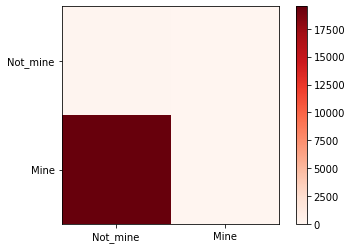

In [294]:
churm = matriz_confusion(y, y_pred, plt.cm.Reds)

In [295]:
pd.DataFrame(churm)

,0,1
0,129,0
1,19511,0


In [296]:
metricas(y, y_pred, churm)

Exactitud:  0.006568228105906314
Kappa:  0.0
Predicciones de los registros mineros
Precisión:  0.0
Recall:  0.0
Especificidad :  0.0
F1-score      :  0.0
Predicciones de los registros no mineros
Precisión:  0.006568228105906314
Recall:  1.0
Especificidad :  1.0
F1-score      :  0.01305073600080935


C:\Users\S T E V E N\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Experimento 2

In [297]:
print(colored('Caracteristicas del conjunto de datos puro', attrs=['bold']))
print(best_feature_sel)

Caracteristicas del conjunto de datos puro
['#dp', '#sp', 'Avg_bpp', 'first_dp', 'first_sp', 'min_d', 'p1_d', 'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_ib', 'second_dp', 'second_sp']


In [298]:
print(colored('Caracteristicas del conjunto de datos no puro', attrs=['bold']))
best_feature_noPure = ['#Bytes', '#dp', '#packets', '#sp', 'Avg_bpp', 'Avg_bps',
       'Avg_pps', 'duration', 'first_dp', 'p2_d', 'p2_ib', 'p3_d',
       'p3_ip', 'second_dp', 'second_sp', 'third_dp', 'third_sp']
print(best_feature_noPure)

Caracteristicas del conjunto de datos no puro
['#Bytes', '#dp', '#packets', '#sp', 'Avg_bpp', 'Avg_bps', 'Avg_pps', 'duration', 'first_dp', 'p2_d', 'p2_ib', 'p3_d', 'p3_ip', 'second_dp', 'second_sp', 'third_dp', 'third_sp']


In [299]:
print(colored('Combino las caracteristicas', attrs=['bold']))
bestFeature = np.concatenate([best_feature_sel,best_feature_noPure])
bestFeature = np.unique(bestFeature)
bestFeature

Combino las caracteristicas


array(['#Bytes', '#dp', '#packets', '#sp', 'Avg_bpp', 'Avg_bps',
       'Avg_pps', 'duration', 'first_dp', 'first_sp', 'min_d', 'p1_d',
       'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_d', 'p3_ib', 'p3_ip',
       'second_dp', 'second_sp', 'third_dp', 'third_sp'], dtype='<U9')

### Preprocesamiento

In [300]:
dataB = pd.read_csv('./data_no_identificada.csv').drop(['index','Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataB.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type', 'Cryptocurrency'],
      dtype='object')

### Imputar valores

In [301]:
punter = pd.concat([dataB['second_sp'],dataB['third_sp'],dataB['second_dp'],dataB['third_dp']], axis = 1)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
values = imputer.fit_transform(punter)

In [302]:
values = pd.DataFrame(values, columns = punter.columns)
dataB['second_sp'] = values['second_sp']
dataB['third_sp'] = values['third_sp']
dataB['second_dp'] = values['second_dp']
dataB['third_dp'] = values['third_dp']

In [303]:
dataCopyB = dataB

In [304]:
print(colored('Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo', attrs=['bold']))
porcion_no_minera_conjuntoA = dataCopyA[dataCopyA.Type == "not_mine"]
porcion_no_minera_conjuntoA = porcion_no_minera_conjuntoA.sample(n=1751)
dataCopyA = pd.concat([porcion_no_minera_conjuntoA, dataCopyA[dataCopyA.Type == "mine"]])

Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo


In [305]:
print(colored('Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos', attrs=['bold']))
porcion_minera_conjuntoB = dataCopyB[dataCopyB.Type == "mine"]
porcion_minera_conjuntoB = porcion_minera_conjuntoB.sample(n=dataCopyA[dataCopyA.Type == "mine"].shape[0])

Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos


In [306]:
porcion_no_minera_conjuntoA = porcion_no_minera_conjuntoA.index
porcion_no_minera_conjuntoA

Int64Index([3593,  743,  585, 2805, 1079, 1624, 4495,  283, 4454, 2040,
            ...
            2603, 3967, 3432, 3719, 1959, 3568, 1458,  484, 1718, 1382],
           dtype='int64', length=1751)

In [307]:
porcion_minera_conjuntoB = porcion_minera_conjuntoB.index
porcion_minera_conjuntoB

Int64Index([22037, 16800, 11361, 36134, 35499, 33428, 12224, 39358, 15426,
             2700,
            ...
            34481, 23893,  8930,  1706, 38438, 17563, 19472, 37212, 32118,
            28295],
           dtype='int64', length=2232)

In [308]:
print(colored('Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros', attrs=['bold']))


Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros


In [309]:
data_final = pd.concat([dataCopyA, data_N_Mineros], axis = 0)
data_final.shape

(6215, 29)

In [310]:
print(colored('Aleatoriedad', attrs=['bold']))
data_final = data_final.reset_index()
indices = list(data_final.index)
random.shuffle(indices)
data_final = data_final.reindex(indices)
data_final.head()

Aleatoriedad


,index,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,...,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
1279,299,489,TCP,0.000,0.3390,40.04400,8598.915,61.637,0.0,8676,...,53.0,80.0,1.0,5.0,13.0,48.0,376.0,2905.0,not_mine,Does not have
1322,4488,255,UDP,0.000,0.0000,0.37100,438.607,15.513,0.0,1005,...,443.0,34048.0,1.0,1.0,3.0,38.0,77.0,298.0,not_mine,Does not have
1258,1178,53,TCP,75.780,103.9360,135.16400,5146.678,149.612,0.0,262,...,80.0,1900.0,4.0,5.0,6.0,96.0,160.0,248.0,not_mine,Does not have
5374,1275,32,ICMP6,0.000,0.0000,0.00000,737.024,361.774,0.0,67,...,1281.0,3333.0,1.0,1.0,1.0,32.0,32.0,66.0,mine,Unidentified
990,1309,64,TCP,73.728,104.3555,123.79575,6012.589,180.083,0.0,338,...,80.0,1900.0,4.0,5.0,6.0,120.0,160.0,248.0,not_mine,Does not have


In [311]:
data_final.isnull().sum()

index             0
Netflows          0
First_Protocol    0
p1_d              0
p2_d              0
p3_d              0
duration          0
max_d             0
min_d             0
#packets          0
Avg_bps           0
Avg_pps           0
Avg_bpp           0
#Bytes            0
#sp               0
#dp               0
first_sp          0
second_sp         0
third_sp          0
first_dp          0
second_dp         0
third_dp          0
p1_ip             0
p2_ip             0
p3_ip             0
p1_ib             0
p2_ib             0
p3_ib             0
Type              0
Cryptocurrency    0
dtype: int64

### OneHotEncoder

In [312]:
data_categoric = data_final.select_dtypes(['object'])
one_hot =  OneHotEncoder()
one_hot.fit_transform(data_categoric)
dataDummy = pd.get_dummies(data_categoric)
data_final = data_final.drop(data_categoric.columns, axis = 1)
data_final = pd.concat([data_final,dataDummy],axis = 1)
data_final.head(1)

,index,Netflows,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,Cryptocurrency_Does not have,Cryptocurrency_Etherium,Cryptocurrency_Litecoin,Cryptocurrency_Monero,Cryptocurrency_Unidentified
1279,299,489,0.0,0.339,40.044,8598.915,61.637,0.0,8676,601186,...,0,0,1,0,0,1,0,0,0,0


### Modelo

In [314]:
X = data_final[bestFeature]
y = data_final['Type_mine']

In [315]:
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [316]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=False)

for key in scores:
    score = scores[key]
    print("%s: %0.2f (+/- %0.2f)" % (key, score.mean(), score.std() * 2))


fit_time: 0.15 (+/- 0.11)
score_time: 0.03 (+/- 0.02)
test_accuracy: 1.00 (+/- 0.01)
test_precision_weighted: 1.00 (+/- 0.01)
test_recall_weighted: 1.00 (+/- 0.01)
test_f1_weighted: 1.00 (+/- 0.01)


In [317]:
K_fold = KFold(n_splits = 10)

In [321]:
resultados_train = []
resultados_test = []
predicciones = []
scores = []
modelos = []


for result in K_fold.split(X):
    resultados_train.append(result[0])
    resultados_test.append(result[1])
    X_train = X.iloc[result[0]]
    X_test =  X.iloc[result[1]]
    y_train =  y.iloc[result[0]]
    y_test =  y.iloc[result[1]]
    model = model.fit(X_train,y_train)
    modelos.append(model)
    predic = model.predict(X_test)
    predicciones.append(predic)
    scores.append(model.score(X_test, y_test))

In [322]:
scores

[0.9935691318327974,
 0.9951768488745981,
 0.9967845659163987,
 0.9983922829581994,
 0.9983922829581994,
 0.9951690821256038,
 0.9951690821256038,
 0.9951690821256038,
 0.9887278582930756,
 0.998389694041868]

Matriz de confusión


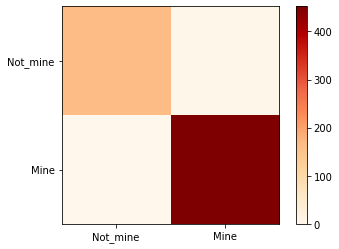

In [327]:
churm = matriz_confusion(y.iloc[resultados_test[0]], predicciones[0], plt.cm.OrRd)

In [328]:
pd.DataFrame(churm)

,0,1
0,166,4
1,0,452


In [329]:
metricas(y.iloc[resultados_test[0]], predicciones[0], churm)

Exactitud:  0.9935691318327974
Kappa:  0.983690807069065
Predicciones de los registros mineros
Precisión:  0.9912280701754386
Recall:  1.0
Especificidad :  1.0
F1-score      :  0.9955947136563876
Predicciones de los registros no mineros
Precisión:  1.0
Recall:  0.9764705882352941
Especificidad :  0.9764705882352941
F1-score      :  0.988095238095238


### Prueba final

In [330]:
porcion_no_minera_conjuntoA

Int64Index([3593,  743,  585, 2805, 1079, 1624, 4495,  283, 4454, 2040,
            ...
            2603, 3967, 3432, 3719, 1959, 3568, 1458,  484, 1718, 1382],
           dtype='int64', length=1751)

In [331]:
porcion_minera_conjuntoB

Int64Index([22037, 16800, 11361, 36134, 35499, 33428, 12224, 39358, 15426,
             2700,
            ...
            34481, 23893,  8930,  1706, 38438, 17563, 19472, 37212, 32118,
            28295],
           dtype='int64', length=2232)

In [332]:
dataRestanteC = dataC[~dataC['index'].isin(porcion_no_minera_conjuntoA)]

In [333]:
dataRestanteC = dataC[~dataC['index'].isin(porcion_minera_conjuntoB)]

In [334]:
X_p = dataRestanteC[bestFeature]
y_p = dataRestanteC['Type'].replace({'mine':1,'not_mine':0})

In [335]:
y_pred_proba = modelos[0].predict(X_p)

Matriz de confusión


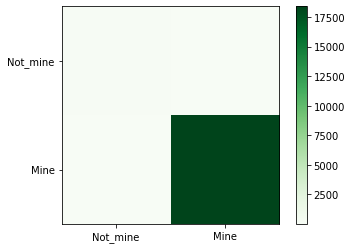

In [336]:
churm = matriz_confusion(y_p, y_pred_proba, plt.cm.Greens)

In [337]:
pd.DataFrame(churm)

,0,1
0,115,2
1,16,18407


In [339]:
metricas(y_p, y_pred_proba, churm)

Exactitud:  0.9990291262135922
Kappa:  0.9269322172170397
Predicciones de los registros mineros
Precisión:  0.9998913574881851
Recall:  0.999131520382131
Especificidad :  0.999131520382131
F1-score      :  0.9995112945264987
Predicciones de los registros no mineros
Precisión:  0.8778625954198473
Recall:  0.9829059829059829
Especificidad :  0.9829059829059829
F1-score      :  0.9274193548387097


In [ ]:
y_pred_proba = model.predict_proba(X_test)

In [ ]:
lr_probs = y_pred_proba[:,1]

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]

In [ ]:
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_auc

In [ ]:
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
lr_auc

In [ ]:
#Sumo los scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Treeb: ROC AUC=%.3f' % (lr_auc))

In [ ]:
ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)

In [ ]:
#Plot la roc curva para el modelo
plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Holdaunt 70% pero debo hacer una validadci{on cruzada en este conjunto de entrenamiento (Puros), de este cruz validation saldra un modelo, y lo testeo con el 30%, con este porcentaje, le saco las metricas